<a href="https://colab.research.google.com/github/LNshuti/usgov-contracts-rag/blob/main/ml_usgov_contracts_ecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hnswlib --quiet
!pip install shap gradio --quiet
!pip install "xgboost_ray" --quiet
!pip install squarify --quiet
!pip install ipython-autotime --quiet

In [2]:
%load_ext autotime

time: 212 µs (started: 2024-11-14 04:38:55 +00:00)


In [3]:
#  Import libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import hnswlib

from sklearn import preprocessing
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from xgboost_ray import RayDMatrix, RayParams, train
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap

# Suppress warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


time: 9.64 s (started: 2024-11-14 04:38:55 +00:00)


In [6]:
# prompt: Use alternative encoding UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 1499: invalid start byte

import pandas as pd

df = pd.read_csv('fy2022_archived_opportunities_5000_rows.csv', encoding='latin-1', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 97ec6ab3d5d4454192a8828827de6f2f to 14f3e98099f749a9a0a37f8bfefad1d1
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Title                     4999 non-null   object 
 1   Sol#                      4955 non-null   object 
 2   Department/Ind.Agency     4998 non-null   object 
 3   CGAC                      4998 non-null   float64
 4   Sub-Tier                  4993 non-null   object 
 5   FPDS Code                 4998 non-null   object 
 6   Office                    4998 non-null   object 
 7   AAC Code                  4952 non-null   object 
 8   PostedDate                4999 non-null   object 
 9   Type                      4999 non-null   object 
 10  BaseType                  4999 non-null   object 
 11  ArchiveType               4999 non-null   object 
 12  ArchiveDate               4550 non-null   object 
 13  SetASideC

In [7]:
df = df.head(800)

time: 497 µs (started: 2024-11-14 04:40:08 +00:00)


In [8]:
df

,Title,Sol#,Department/Ind.Agency,CGAC,Sub-Tier,FPDS Code,Office,AAC Code,PostedDate,Type,...,SecondaryContactPhone,SecondaryContactFax,OrganizationType,State,City,ZipCode,CountryCode,AdditionalInfoLink,Link,Description
NoticeId,,,,,,,,,,,,,,,,,,,,,
97ec6ab3d5d4454192a8828827de6f2f,Whooster Web-Based Software,HQ003422P0171,DEPT OF DEFENSE,97.0,WASHINGTON HEADQUARTERS SERVICES (WHS),97F5,WASHINGTON HEADQUARTERS SERVICES,HQ0034,2022-09-30 23:09:21.289-04,Award Notice,...,NaN,NaN,OFFICE,DC,WASHINGTON,203011000,USA,NaN,https://sam.gov/opp/97ec6ab3d5d4454192a8828827...,The Whooster Web Based Software contract is a ...
c15a7148317b44eeac210a7b64068765,Beckman Coulter Reagents and Supplies for Gove...,W81K0222Q0162,DEPT OF DEFENSE,21.0,DEPT OF THE ARMY,2100,W40M RHCO PACIFIC,W81K02,2022-09-30 23:01:45.502-04,Presolicitation,...,NaN,NaN,OFFICE,HI,FORT SHAFTER,96858-5098,USA,NaN,https://sam.gov/opp/c15a7148317b44eeac210a7b64...,The Medical Readiness Contracting Office  Pac...
bf103afa7b4b455bb1541eb450e38128,8(a) WebEOC IL5 Cloud Services and IT Support,HQ003422C0130,DEPT OF DEFENSE,97.0,WASHINGTON HEADQUARTERS SERVICES (WHS),97F5,WASHINGTON HEADQUARTERS SERVICES,HQ0034,2022-09-30 22:12:14.082-04,Award Notice,...,NaN,NaN,OFFICE,DC,WASHINGTON,203011000,USA,NaN,https://sam.gov/opp/bf103afa7b4b455bb1541eb450...,Direct Award of an 8(a) contract for WebEOC IL...
d1619b0084ac4d439585b727343b4659,Leslie Valve IDIQ - Sources Sought,N4523A22RC04N81,DEPT OF DEFENSE,17.0,DEPT OF THE NAVY,1700,PUGET SOUND NAVAL SHIPYARD IMF,N4523A,2022-09-30 22:05:45.599-04,Sources Sought,...,3609793943,NaN,OFFICE,WA,BREMERTON,98314-5001,USA,NaN,https://sam.gov/opp/d1619b0084ac4d439585b72734...,Puget Sound Naval Shipyard and Intermediate Ma...
48b6b27846bd4155990cdc2f2be335c5,PFPA BALLISTIC VEST AND PLATES,HQ003422Q0206,DEPT OF DEFENSE,97.0,WASHINGTON HEADQUARTERS SERVICES (WHS),97F5,WASHINGTON HEADQUARTERS SERVICES,HQ0034,2022-09-30 21:36:36.954-04,Award Notice,...,NaN,NaN,OFFICE,DC,WASHINGTON,203011000,USA,NaN,https://sam.gov/opp/48b6b27846bd4155990cdc2f2b...,This blanket purchase agreement (BPA) has been...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f22a9e4ce0a5400191f4fb5d712fbb20,"59--CABLE ASSEMBLY,RADI",SPE4A622Q0357,DEPT OF DEFENSE,97.0,DEFENSE LOGISTICS AGENCY (DLA),97AS,DLA AVIATION,SPE4A6,2022-09-29 15:06:15.524-04,Award Notice,...,NaN,NaN,OFFICE,VA,RICHMOND,23237,USA,NaN,https://sam.gov/opp/f22a9e4ce0a5400191f4fb5d71...,NaN
56c210ab064b4ad3a49044057e325734,"63--CONTROL,ELECTRONIC",SPE4A622RXE38,DEPT OF DEFENSE,97.0,DEFENSE LOGISTICS AGENCY (DLA),97AS,DLA AVIATION,SPE4A6,2022-09-29 15:06:07.063-04,Award Notice,...,NaN,NaN,OFFICE,VA,RICHMOND,23237,USA,NaN,https://sam.gov/opp/56c210ab064b4ad3a49044057e...,NaN
965de3ad20934d2ab60c6aad43a3a5e2,FY23 BASE GALVESTON REFUSE COLLECTION SERVICES,70Z02922QNEWO0060,"HOMELAND SECURITY, DEPARTMENT OF",70.0,US COAST GUARD,7008,BASE NEW ORLEANS(00029),70Z029,2022-09-29 15:06:06.515-04,Solicitation,...,NaN,NaN,OFFICE,LA,NEW ORLEANS,70117,USA,NaN,https://sam.gov/opp/965de3ad20934d2ab60c6aad43...,FY 2023 refuse & recycling collection services...


time: 32.2 ms (started: 2024-11-14 04:40:10 +00:00)


In [18]:
df2023 = pd.read_csv('fy2023_archived_opportunities_5000_rows.csv', encoding='latin-1', index_col=0)
df2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4987 entries, 3628df647dd64f6bb9e5e5bd81eaab06 to c2a509bba9a74feb979c66a255735297
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Title                     4987 non-null   object 
 1   Sol#                      4949 non-null   object 
 2   Department/Ind.Agency     4987 non-null   object 
 3   CGAC                      4987 non-null   int64  
 4   Sub-Tier                  4979 non-null   object 
 5   FPDS Code                 4987 non-null   object 
 6   Office                    4987 non-null   object 
 7   AAC Code                  4957 non-null   object 
 8   PostedDate                4987 non-null   object 
 9   Type                      4987 non-null   object 
 10  BaseType                  4987 non-null   object 
 11  ArchiveType               4987 non-null   object 
 12  ArchiveDate               4568 non-null   object 
 13  SetASideC

In [19]:
df2023

,Title,Sol#,Department/Ind.Agency,CGAC,Sub-Tier,FPDS Code,Office,AAC Code,PostedDate,Type,...,SecondaryContactPhone,SecondaryContactFax,OrganizationType,State,City,ZipCode,CountryCode,AdditionalInfoLink,Link,Description
NoticeId,,,,,,,,,,,,,,,,,,,,,
3628df647dd64f6bb9e5e5bd81eaab06,Black Rock Lock Lower MITRE Gate Installation,W912P422B0019,DEPT OF DEFENSE,21,DEPT OF THE ARMY,2100,W072 ENDIST BUFFALO,W912P4,2022-11-10 15:45:16.852-05,Solicitation,...,7168794126,NaN,OFFICE,NY,BUFFALO,14207-3199,USA,NaN,https://sam.gov/opp/3628df647dd64f6bb9e5e5bd81...,"The BRL MITRE Gates installation consists of, ..."
abc3eac976bb4239bcbe7629c6afdf95,PFPA Law Enforcement Duty Gear Equipment,WB111020221449,DEPT OF DEFENSE,97,WASHINGTON HEADQUARTERS SERVICES (WHS),97F5,WASHINGTON HEADQUARTERS SERVICES,HQ0034,2022-11-10 15:44:09.961-05,Sources Sought,...,NaN,NaN,OFFICE,DC,WASHINGTON,203011000,USA,NaN,https://sam.gov/opp/abc3eac976bb4239bcbe7629c6...,THIS IS NOT A REQUEST FOR QUOTES/PROPOSALS and...
dc6d23486a0e4574bf6fc799ee4262bb,Crane Hoisting Services,W50SLF-23-Q-0001,DEPT OF DEFENSE,21,DEPT OF THE ARMY,2100,W7M4 USPFO ACTIVITY HIANG 154,W50SLF,2022-11-10 15:25:21.391-05,Combined Synopsis/Solicitation,...,8088446422,8088446340,OFFICE,HI,HONOLULU,96816-4495,USA,NaN,https://sam.gov/opp/dc6d23486a0e4574bf6fc799ee...,This is a combined synopsis/solicitation for c...
a4f5d2bc671d4804be95cd363806982b,Emergency Flood Repairs of Elevators and Eleva...,36C26123C0009,"VETERANS AFFAIRS, DEPARTMENT OF",36,"VETERANS AFFAIRS, DEPARTMENT OF",3600,261-NETWORK CONTRACT OFFICE 21 (36C261),36C261,2022-11-10 14:49:22.997-05,Award Notice,...,NaN,NaN,OFFICE,CA,MATHER,95655,USA,NaN,https://sam.gov/opp/a4f5d2bc671d4804be95cd3638...,Emergency Flood Repairs of Elevators and Eleva...
be26926501194cdabf78055d47292623,Emergency Flood Repairs of Elevators and Eleva...,36C26123C0009,"VETERANS AFFAIRS, DEPARTMENT OF",36,"VETERANS AFFAIRS, DEPARTMENT OF",3600,261-NETWORK CONTRACT OFFICE 21 (36C261),36C261,2022-11-10 14:41:49.351-05,Award Notice,...,NaN,NaN,OFFICE,CA,MATHER,95655,USA,NaN,https://sam.gov/opp/be26926501194cdabf78055d47...,Emergency Flood Repairs of Elevators and Eleva...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9d4c69ee6ce4495d85181b60903ff679,Propulsion Diesel and SSDG Seawater Strainer B...,N32253-23-Q-0005,DEPT OF DEFENSE,17,DEPT OF THE NAVY,1700,PEARL HARBOR NAVAL SHIPYARD IMF,N32253,2022-10-13 18:39:37.125-04,Presolicitation,...,NaN,NaN,OFFICE,HI,PEARL HARBOR,96860-5033,USA,NaN,https://sam.gov/opp/9d4c69ee6ce4495d85181b6090...,The Pearl Harbor Naval Shipyard and Intermedia...
7bcb317dc04841b999f0641b759cd521,S206--593-23-2-771-0002 Police K9 Program,36C26123Q0046,"VETERANS AFFAIRS, DEPARTMENT OF",36,"VETERANS AFFAIRS, DEPARTMENT OF",3600,261-NETWORK CONTRACT OFFICE 21 (36C261),36C261,2022-10-13 18:35:22.472-04,Sources Sought,...,NaN,NaN,OFFICE,CA,MATHER,95655,USA,NaN,https://sam.gov/opp/7bcb317dc04841b999f0641b75...,The Department of Veterans Affairs at the Sout...
340869a93b364144ae242447bbaa43a4,Enclosed Operations Cargo Trailers,127EAT22P0080,"AGRICULTURE, DEPARTMENT OF",12,FOREST SERVICE,12C2,"USDA-FS, CSA SOUTHWEST 3",127EAT,2022-10-13 18:34:26.097-04,Award Notice,...,NaN,NaN,OFFICE,NM,Albuquerque,871023498,USA,NaN,https://sam.gov/opp/340869a93b364144ae242447bb...,Enclosed Cargo Trailers


time: 23.1 ms (started: 2024-11-14 04:45:09 +00:00)


In [20]:
df2023.columns

Index(['Title', 'Sol#', 'Department/Ind.Agency', 'CGAC', 'Sub-Tier',
       'FPDS Code', 'Office', 'AAC Code', 'PostedDate', 'Type', 'BaseType',
       'ArchiveType', 'ArchiveDate', 'SetASideCode', 'SetASide',
       'ResponseDeadLine', 'NaicsCode', 'ClassificationCode',
       'PopStreetAddress', 'PopCity', 'PopState', 'PopZip', 'PopCountry',
       'Active', 'AwardNumber', 'AwardDate', 'Award$', 'Awardee',
       'PrimaryContactTitle', 'PrimaryContactFullname', 'PrimaryContactEmail',
       'PrimaryContactPhone', 'PrimaryContactFax', 'SecondaryContactTitle',
       'SecondaryContactFullname', 'SecondaryContactEmail',
       'SecondaryContactPhone', 'SecondaryContactFax', 'OrganizationType',
       'State', 'City', 'ZipCode', 'CountryCode', 'AdditionalInfoLink', 'Link',
       'Description'],
      dtype='object')

time: 3.21 ms (started: 2024-11-14 04:45:11 +00:00)


In [21]:
import pandas as pd

def clean_column_names(df):
    # Replace spaces and slashes with underscores
    df.columns = [col.replace(' ', '_').replace('/', '_') for col in df.columns]
    # Convert to lowercase
    df.columns = [col.lower() for col in df.columns]
    return df

# Assuming df2023 is your DataFrame
df2023 = clean_column_names(df2023)
df2023.columns

Index(['title', 'sol#', 'department_ind.agency', 'cgac', 'sub-tier',
       'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype',
       'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award$', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

time: 4.27 ms (started: 2024-11-14 04:45:23 +00:00)


In [22]:
def separate_columns(df):
    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

    return categorical_cols, numerical_cols

# Assuming df2023 is your DataFrame (already cleaned)
categorical_columns, numerical_columns = separate_columns(df2023)

print("Categorical Columns:")
print(categorical_columns)
print("\nNumerical Columns:")
numerical_columns

Categorical Columns:
['title', 'sol#', 'department_ind.agency', 'sub-tier', 'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype', 'archivedate', 'setasidecode', 'setaside', 'responsedeadline', 'classificationcode', 'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry', 'active', 'awardnumber', 'awarddate', 'awardee', 'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail', 'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle', 'secondarycontactfullname', 'secondarycontactemail', 'secondarycontactphone', 'secondarycontactfax', 'organizationtype', 'state', 'city', 'zipcode', 'countrycode', 'link', 'description']

Numerical Columns:


['cgac', 'naicscode', 'award$', 'additionalinfolink']

time: 6.48 ms (started: 2024-11-14 04:45:33 +00:00)


In [23]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier

# Define categorical columns
categorical_cols = categorical_columns

# One-hot encode categorical variables
encoder = OneHotEncoder()

time: 453 µs (started: 2024-11-14 04:45:35 +00:00)


In [24]:
encoder

OneHotEncoder()

time: 3.44 ms (started: 2024-11-14 04:45:37 +00:00)


In [25]:
df2023.columns

Index(['title', 'sol#', 'department_ind.agency', 'cgac', 'sub-tier',
       'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype',
       'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award$', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

time: 4.22 ms (started: 2024-11-14 04:45:38 +00:00)


In [26]:
X_categorical = encoder.fit_transform(df2023[categorical_cols])
X_categorical_df = pd.DataFrame(X_categorical.toarray(), columns=encoder.get_feature_names_out(categorical_cols))
X_categorical_df

title_"AHU Replacement", Pasadena, CA  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   
...                                     ...   
4982                                    0.0   
4983                                    0.0   
4984                                    0.0   
4985                                    0.0   
4986                                    0.0   

      title_"On-Call" Repair and Maintain Pavements and Grounds IDIQ  \
0                                                   0.0                
1                                                   0.0                
2                                                   0.0                
3                                                   0.0                
4                                                   0.0                
...                                                 ...                
4982                                                0.0                
4983                                                0.0                
4984                                                0.0                
4985                                                0.0                
4986                                                0.0                

      title_(3 ea) Dell PowerEdge R750 servers  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
4982                                       0.0   
4983                                       0.0   
4984                                       0.0   
4985                                       0.0   
4986                                       0.0   

      title_***NOTICE OF AWARD**** Test Pilot School (TPS) Glider Blanket Purchase Agreement  \
0                                                   0.0                                        
1                                                   0.0                                        
2                                                   0.0                                        
3                                                   0.0                                        
4                                                   0.0                                        
...                                                 ...                                        
4982                                                0.0                                        
4983                                                0.0                                        
4984                                                0.0                                        
4985                                                0.0                                        
4986                                                0.0                                        

      title_**Reminder** Robins AFB Contracting Directorate Industry Outreach Automatic Test Systems (ATS) Program Office  \
0                                                   0.0                                                                     
1                                                   0.0                                                                     
2                                                   0.0                                                                     
3                                                   0.0                                                                     
4                                                   0.0                                                                     
...                                                 ...                 

time: 454 ms (started: 2024-11-14 04:45:40 +00:00)


In [27]:
import re

def clean_names(df):
    """
    Cleans column names of a Pandas DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Pandas DataFrame

    Returns:
        Pandas DataFrame with cleaned column names.
    """
    new_cols = []
    for col in df.columns:
        # Remove special characters
        col = re.sub(r'[^\w\s]', '', col)
        # Convert to lowercase
        col = col.lower()
        # Replace spaces with underscores
        col = col.replace(' ', '_')
        new_cols.append(col)
    df.columns = new_cols
    return df

X_categorical_df_clean = clean_names(X_categorical_df)

time: 274 ms (started: 2024-11-14 04:45:47 +00:00)


In [28]:
X_categorical_df_clean

title_ahu_replacement_pasadena_ca  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   
...                                 ...   
4982                                0.0   
4983                                0.0   
4984                                0.0   
4985                                0.0   
4986                                0.0   

      title_oncall_repair_and_maintain_pavements_and_grounds_idiq  \
0                                                   0.0             
1                                                   0.0             
2                                                   0.0             
3                                                   0.0             
4                                                   0.0             
...                                                 ...             
4982                                                0.0             
4983                                                0.0             
4984                                                0.0             
4985                                                0.0             
4986                                                0.0             

      title_3_ea_dell_poweredge_r750_servers  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   
...                                      ...   
4982                                     0.0   
4983                                     0.0   
4984                                     0.0   
4985                                     0.0   
4986                                     0.0   

      title_notice_of_award_test_pilot_school_tps_glider_blanket_purchase_agreement  \
0                                                   0.0                               
1                                                   0.0                               
2                                                   0.0                               
3                                                   0.0                               
4                                                   0.0                               
...                                                 ...                               
4982                                                0.0                               
4983                                                0.0                               
4984                                                0.0                               
4985                                                0.0                               
4986                                                0.0                               

      title_reminder_robins_afb_contracting_directorate_industry_outreach_automatic_test_systems_ats_program_office  \
0                                                   0.0                                                               
1                                                   0.0                                                               
2                                                   0.0                                                               
3                                                   0.0                                                               
4                                                   0.0                                                               
...                                                 ...                                                               
4982                                                0.0                                                               
4983                                                0.0                               

time: 69.4 ms (started: 2024-11-14 04:45:50 +00:00)


In [30]:
df.columns

Index(['Title', 'Sol#', 'Department/Ind.Agency', 'CGAC', 'Sub-Tier',
       'FPDS Code', 'Office', 'AAC Code', 'PostedDate', 'Type', 'BaseType',
       'ArchiveType', 'ArchiveDate', 'SetASideCode', 'SetASide',
       'ResponseDeadLine', 'NaicsCode', 'ClassificationCode',
       'PopStreetAddress', 'PopCity', 'PopState', 'PopZip', 'PopCountry',
       'Active', 'AwardNumber', 'AwardDate', 'Award$', 'Awardee',
       'PrimaryContactTitle', 'PrimaryContactFullname', 'PrimaryContactEmail',
       'PrimaryContactPhone', 'PrimaryContactFax', 'SecondaryContactTitle',
       'SecondaryContactFullname', 'SecondaryContactEmail',
       'SecondaryContactPhone', 'SecondaryContactFax', 'OrganizationType',
       'State', 'City', 'ZipCode', 'CountryCode', 'AdditionalInfoLink', 'Link',
       'Description'],
      dtype='object')

time: 3.57 ms (started: 2024-11-14 04:46:11 +00:00)


In [33]:
df[["Sub-Tier"]].value_counts()

,count
Sub-Tier,
DEPT OF THE ARMY,166
DEPT OF THE NAVY,117
DEFENSE LOGISTICS AGENCY (DLA),80
DEPT OF THE AIR FORCE,62
"VETERANS AFFAIRS, DEPARTMENT OF",58
...,...
OFFICE OF THE ASSISTANT SECRETARY FOR ADMINISTRATION AND MANAGEMENT,1
ADMINISTRATIVE OFFICE OF THE US COURTS,1
OFFICE OF PERSONNEL MANAGEMENT,1


time: 7.55 ms (started: 2024-11-14 04:46:51 +00:00)


In [35]:
def clean_artists(artists_str):
    """
    Cleans the artists string by removing special characters and extra whitespace.
    Handles cases where artists_str might be a non-string type.
    """
    if not isinstance(artists_str, str):
        return ""  # Or handle the non-string case as needed
    cleaned_str = re.sub(r'[^\w\s]', '', artists_str)  # Remove special characters
    cleaned_str = ' '.join(cleaned_str.split())  # Remove extra whitespace
    return cleaned_str

# Apply the function to the 'artists' column
df['AwardDate'] = df['AwardDate'].apply(clean_artists)
df[["AwardDate"]].value_counts()

,count
AwardDate,
,286
20220929,205
20220930,115
20220928,46
20220927,30
20220923,27
20220926,25
20220921,9
20220922,7


time: 8.58 ms (started: 2024-11-14 04:47:20 +00:00)


In [36]:
from sklearn.feature_extraction import FeatureHasher

time: 385 µs (started: 2024-11-14 04:47:23 +00:00)


In [37]:
help(FeatureHasher)

Help on class FeatureHasher in module sklearn.feature_extraction._hash:

class FeatureHasher(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  FeatureHasher(n_features=1048576, *, input_type='dict', dtype=<class 'numpy.float64'>, alternate_sign=True)
 |  
 |  Implements feature hashing, aka the hashing trick.
 |  
 |  This class turns sequences of symbolic feature names (strings) into
 |  scipy.sparse matrices, using a hash function to compute the matrix column
 |  corresponding to a name. The hash function employed is the signed 32-bit
 |  version of Murmurhash3.
 |  
 |  Feature names of type byte string are used as-is. Unicode strings are
 |  converted to UTF-8 first, but no Unicode normalization is done.
 |  Feature values must be (finite) numbers.
 |  
 |  This class is a low-memory alternative to DictVectorizer and
 |  CountVectorizer, intended for large-scale (online) learning and situations
 |  where memory is tight, e.g. when running prediction code on embedded
 |

In [38]:

h = FeatureHasher(n_features=10, input_type='string')

time: 503 µs (started: 2024-11-14 04:47:30 +00:00)


In [39]:
h

FeatureHasher(input_type='string', n_features=10)

time: 4.09 ms (started: 2024-11-14 04:47:31 +00:00)


In [40]:
# Cell 4: Define function to hash text features
def hash_text_features(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: hash(str(x)) % 10**8)  # Convert to string and hash
    return df


time: 418 µs (started: 2024-11-14 04:55:12 +00:00)


In [42]:
df2023.columns

Index(['title', 'sol#', 'department_ind.agency', 'cgac', 'sub-tier',
       'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype',
       'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award$', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

time: 3.34 ms (started: 2024-11-14 04:55:51 +00:00)


In [43]:

# Apply the function to the text columns
all_cols = df2023.columns
df_hashed = hash_text_features(df2023.copy(), all_cols)

time: 115 ms (started: 2024-11-14 04:56:43 +00:00)


In [44]:
df_hashed

,title,sol#,department_ind.agency,cgac,sub-tier,fpds_code,office,aac_code,posteddate,type,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
NoticeId,,,,,,,,,,,,,,,,,,,,,
3628df647dd64f6bb9e5e5bd81eaab06,95890071,58871937,17818128,61635991,41692784,28401402,12421874,97439045,39782094,56588684,...,78248619,39287711,38484366,17408119,52519851,53495377,812442,39287711,83787095,98147607
abc3eac976bb4239bcbe7629c6afdf95,39736434,60309890,17818128,33756262,45539667,29946323,52098303,17664220,92046488,2447415,...,39287711,39287711,38484366,92916872,7875202,64145922,812442,39287711,44272329,57088488
dc6d23486a0e4574bf6fc799ee4262bb,59912544,93570303,17818128,61635991,41692784,28401402,62430533,95522592,58186422,7428079,...,97062646,87206566,38484366,59326090,44386888,72012901,812442,39287711,49171903,46140486
a4f5d2bc671d4804be95cd363806982b,26060990,60234202,19601571,77925203,19601571,64284076,15422303,52404923,51953490,65221920,...,39287711,39287711,38484366,18116396,21833881,8914922,812442,39287711,95249873,68096276
be26926501194cdabf78055d47292623,26060990,60234202,19601571,77925203,19601571,64284076,15422303,52404923,87074937,65221920,...,39287711,39287711,38484366,18116396,21833881,8914922,812442,39287711,47629387,46413017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9d4c69ee6ce4495d85181b60903ff679,58135907,81528433,17818128,47844694,77548047,24741856,81643888,29102060,30000718,95161292,...,39287711,39287711,38484366,59326090,56173616,99923820,812442,39287711,4991230,97649469
7bcb317dc04841b999f0641b759cd521,50021874,64178956,19601571,77925203,19601571,64284076,15422303,52404923,46719056,2447415,...,39287711,39287711,38484366,18116396,21833881,8914922,812442,39287711,2726072,16533560
340869a93b364144ae242447bbaa43a4,55209952,26584474,40890414,82216070,5230494,55330026,97123618,25110638,13412369,65221920,...,39287711,39287711,38484366,9101529,82348742,13006412,812442,39287711,34713732,19440847


time: 20.1 ms (started: 2024-11-14 04:56:52 +00:00)


In [45]:
# Cell 5: Normalize numerical columns

scaler = StandardScaler()
df_hashed[all_cols] = scaler.fit_transform(df_hashed[all_cols])

time: 13.4 ms (started: 2024-11-14 04:57:30 +00:00)


In [47]:
df_hashed

,title,sol#,department_ind.agency,cgac,sub-tier,fpds_code,office,aac_code,posteddate,type,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
NoticeId,,,,,,,,,,,,,,,,,,,,,
3628df647dd64f6bb9e5e5bd81eaab06,1.637304,0.310948,-0.421645,0.919604,-0.696721,-0.592019,-0.935892,1.892130,-0.345819,0.034771,...,3.291088,-0.072613,-0.007459,-1.096524,0.136665,0.156820,-0.08261,0.0,1.185183,2.155582
abc3eac976bb4239bcbe7629c6afdf95,-0.296774,0.361053,-0.421645,-0.646624,-0.495594,-0.513444,0.486873,-1.397693,1.454861,-2.017785,...,-0.123790,-0.072613,-0.007459,1.468393,-1.371311,0.500655,-0.08261,0.0,-0.194857,0.435286
dc6d23486a0e4574bf6fc799ee4262bb,0.398144,1.520007,-0.421645,0.919604,-0.696721,-0.592019,0.857379,1.813098,0.288270,-1.828962,...,4.940115,11.802828,-0.007459,0.327365,-0.138045,0.754627,-0.08261,0.0,-0.023741,-0.023414
a4f5d2bc671d4804be95cd363806982b,-0.767791,0.358416,-0.341288,1.834699,-1.851720,1.232979,-0.828299,0.034974,0.073525,0.362067,...,-0.123790,-0.072613,-0.007459,-1.072465,-0.899824,-1.282385,-0.08261,0.0,1.585517,0.896490
be26926501194cdabf78055d47292623,-0.767791,0.358416,-0.341288,1.834699,-1.851720,1.232979,-0.828299,0.034974,1.283574,0.362067,...,-0.123790,-0.072613,-0.007459,-1.072465,-0.899824,-1.282385,-0.08261,0.0,-0.077613,-0.011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9d4c69ee6ce4495d85181b60903ff679,0.336952,1.100410,-0.421645,0.144836,1.177905,-0.778144,1.546354,-0.926009,-0.682820,1.497102,...,-0.123790,-0.072613,-0.007459,0.327365,0.260079,1.655684,-0.08261,0.0,-1.566736,2.134711
7bcb317dc04841b999f0641b759cd521,0.057484,0.495870,-0.341288,1.834699,-1.851720,1.232979,-0.828299,0.034974,-0.106818,-2.017785,...,-0.123790,-0.072613,-0.007459,-1.072465,-0.899824,-1.282385,-0.08261,0.0,-1.645846,-1.263886
340869a93b364144ae242447bbaa43a4,0.236175,-0.814104,0.617935,2.075751,-2.603085,0.777575,2.101445,-1.090611,-1.254343,0.362067,...,-0.123790,-0.072613,-0.007459,-1.378686,1.144204,-1.150298,-0.08261,0.0,-0.528688,-1.142077


time: 21.2 ms (started: 2024-11-14 04:57:46 +00:00)


In [48]:
# Replace empty strings with NaN for consistent handling
df_hashed.replace('', pd.NA, inplace=True)

# Create an Imputer instance with the desired strategy (e.g., 'mean', 'median')
imputer = SimpleImputer(strategy='mean')  # Choose an appropriate strategy

# Apply imputation to all numerical columns
df_hashed[all_cols] = imputer.fit_transform(df_hashed[all_cols])

# Normalize numerical columns
scaler = StandardScaler()
df_hashed[all_cols] = scaler.fit_transform(df_hashed[all_cols])

time: 20.1 ms (started: 2024-11-14 04:58:48 +00:00)


In [50]:
df_hashed.columns

Index(['title', 'sol#', 'department_ind.agency', 'cgac', 'sub-tier',
       'fpds_code', 'office', 'aac_code', 'posteddate', 'type', 'basetype',
       'archivetype', 'archivedate', 'setasidecode', 'setaside',
       'responsedeadline', 'naicscode', 'classificationcode',
       'popstreetaddress', 'popcity', 'popstate', 'popzip', 'popcountry',
       'active', 'awardnumber', 'awarddate', 'award$', 'awardee',
       'primarycontacttitle', 'primarycontactfullname', 'primarycontactemail',
       'primarycontactphone', 'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

time: 2.93 ms (started: 2024-11-14 05:01:26 +00:00)


In [51]:
# Cell 6: Prepare target and features
X = df_hashed.drop(['sol#'], axis=1)  # Remove non-relevant and target columns
y = df_hashed['award$']  # Target variable

# Display the shapes of X and y
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (4987, 45)
Target shape: (4987,)
time: 4.83 ms (started: 2024-11-14 05:02:09 +00:00)


In [52]:
# Cell 7: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Display the shapes of the splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (3989, 45)
X_test shape: (998, 45)
y_train shape: (3989,)
y_test shape: (998,)
time: 8.05 ms (started: 2024-11-14 05:02:15 +00:00)


In [53]:
# Cell 8: Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

time: 3.54 s (started: 2024-11-14 05:02:18 +00:00)


In [54]:
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import plotly

time: 5.09 ms (started: 2024-11-14 05:02:25 +00:00)


In [55]:
# Cell 9: Make predictions and evaluate the model
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5.263104283187518e-06
time: 19.4 ms (started: 2024-11-14 05:02:28 +00:00)


In [56]:
X_train.columns

Index(['title', 'department_ind.agency', 'cgac', 'sub-tier', 'fpds_code',
       'office', 'aac_code', 'posteddate', 'type', 'basetype', 'archivetype',
       'archivedate', 'setasidecode', 'setaside', 'responsedeadline',
       'naicscode', 'classificationcode', 'popstreetaddress', 'popcity',
       'popstate', 'popzip', 'popcountry', 'active', 'awardnumber',
       'awarddate', 'award$', 'awardee', 'primarycontacttitle',
       'primarycontactfullname', 'primarycontactemail', 'primarycontactphone',
       'primarycontactfax', 'secondarycontacttitle',
       'secondarycontactfullname', 'secondarycontactemail',
       'secondarycontactphone', 'secondarycontactfax', 'organizationtype',
       'state', 'city', 'zipcode', 'countrycode', 'additionalinfolink', 'link',
       'description'],
      dtype='object')

time: 4.28 ms (started: 2024-11-14 05:04:14 +00:00)


In [57]:
# Define prediction function to match provided columns
def predict_popularity(title, department_agency, cgac, sub_tier, fpds_code, office, aac_code, posted_date, contract_type, base_type, archive_type, archive_date, set_aside_code, set_aside, response_deadline, naics_code, classification_code, pop_street_address, pop_city, pop_state, pop_zip, pop_country, active, award_number, award_date, award_amount, awardee, primary_contact_title, primary_contact_fullname, primary_contact_email, primary_contact_phone, primary_contact_fax, secondary_contact_title, secondary_contact_fullname, secondary_contact_email, secondary_contact_phone, secondary_contact_fax, organization_type, state, city, zip_code, country_code, additional_info_link, link, description):

    # Hash specific text fields to match the model's expected input format
    title_hashed = hash(str(title)) % 10**8
    department_agency_hashed = hash(str(department_agency)) % 10**8
    sub_tier_hashed = hash(str(sub_tier)) % 10**8
    awardee_hashed = hash(str(awardee)) % 10**8

    # Create a DataFrame for the input, matching the column names in X
    input_data = pd.DataFrame([[
        title_hashed, department_agency_hashed, cgac, sub_tier_hashed, fpds_code,
        office, aac_code, posted_date, contract_type, base_type, archive_type, archive_date,
        set_aside_code, set_aside, response_deadline, naics_code, classification_code,
        pop_street_address, pop_city, pop_state, pop_zip, pop_country, active,
        award_number, award_date, award_amount, awardee_hashed, primary_contact_title,
        primary_contact_fullname, primary_contact_email, primary_contact_phone,
        primary_contact_fax, secondary_contact_title, secondary_contact_fullname,
        secondary_contact_email, secondary_contact_phone, secondary_contact_fax,
        organization_type, state, city, zip_code, country_code, additional_info_link,
        link, description
    ]], columns=X.columns)

    # Define numeric columns, if any, to normalize
    # (Assume 'award_amount' as a numerical example, modify as needed based on your data)
    numerical_cols = ['award_amount']
    input_data[numerical_cols] = (input_data[numerical_cols] - X[numerical_cols].mean()) / X[numerical_cols].std()

    # Return the DataFrame ready for prediction
    return input_data


time: 786 µs (started: 2024-11-14 05:05:01 +00:00)


In [58]:
X_train.dtypes.to_frame('Data Type')

,Data Type
title,float64
department_ind.agency,float64
cgac,float64
sub-tier,float64
fpds_code,float64
office,float64
aac_code,float64
posteddate,float64
type,float64
basetype,float64


time: 12.1 ms (started: 2024-11-14 05:06:18 +00:00)


To better understand columns of type `object`, we will analyze them into each subtype using function `open_object_dtype()`

## <span style='color:#2B9C15 '> 📕 Missing values in each row </span>

We check for missing values in each row. Since the dataset has 20 columns, if any row has more than 10 missing values, we will drop that row.

In [59]:
# Missing values in each row
missing_values_per_row = X_train.isnull().sum(axis=1)
count_per_missing_value = missing_values_per_row.value_counts().sort_index()

# Print the results
for missing, rows in count_per_missing_value.items():
    print(f'{rows} row(s) have {missing} missing values')

total_rows_with_missing_values = (X_train.isnull().any(axis=1)).sum()
print(f'Total number of rows with missing values: {total_rows_with_missing_values}')

3989 row(s) have 0 missing values
Total number of rows with missing values: 0
time: 9.95 ms (started: 2024-11-14 05:07:05 +00:00)


So, all rows have no missing values except for one row with 3 missing values. We will handle this particular row in the subsequent section.


<a class="anchor" id="2"></a>
## <div style="text-align: left; background-color:#867FEE; font-family:newtimeroman;color: black; padding: 14px; line-height: 1;border-radius:10px">2. Data Distribution </div>

#### 👉 What is the percentage of missing values?

To start our analysis, we first examined the numerical columns using the `info()` method.

Subsequently, we calculated the minimum and maximum values for each numerical column, along with the corresponding percentage of missing values.

But in the `key` column (song key), there will be a value of -1 if the key of the song cannot be determined. Therefore, we will calculate the number of missing values in the column by counting the number of -1 values in the 'key' column

In [60]:
dist_numerical_cols = X_train.describe().T[['min', 'max']]
dist_numerical_cols['Missing Values'] = X_train.isnull().sum()
dist_numerical_cols['Missing Percentage'] = (X_train.isnull().mean() * 100).round(2)

time: 56.8 ms (started: 2024-11-14 05:08:17 +00:00)


The output shows that all numeric columns have a missing value percentage of 0, indicating that **there are no missing values** in these columns.

To gain further insights into the data, we used the `describe()` method to generate a comprehensive statistical summary of the numerical columns.

In [61]:
X_train.describe()

,title,department_ind.agency,cgac,sub-tier,fpds_code,office,aac_code,posteddate,type,basetype,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
count,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,...,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.0,3989.000000,3989.000000
mean,0.007337,-0.005235,0.002131,-0.007396,-0.005437,0.010418,-0.003984,0.005672,-0.005189,-0.004120,...,0.003500,0.002613,-0.000200,0.007486,0.001521,0.011765,0.000301,0.0,0.001824,0.010404
std,0.999384,0.997016,0.999283,1.000322,0.994828,1.006869,0.998078,0.998575,1.007534,1.005813,...,1.005367,1.014427,1.063707,0.997058,1.000943,1.000672,0.980971,0.0,0.993515,1.001442
min,-1.663795,-0.864118,-2.204974,-2.782096,-2.005120,-1.371918,-2.118771,-1.715876,-2.017785,-1.855265,...,-3.538911,-8.420692,-18.231176,-1.647896,-1.620350,-1.551495,-0.165860,0.0,-1.740624,-1.952078
25%,-0.901031,-0.421645,-0.646624,-0.342009,-0.778144,-0.798948,-0.656172,-0.873600,0.034771,0.097895,...,-0.123790,-0.072613,-0.007459,-0.989690,-1.044843,-0.907459,-0.082610,0.0,-0.844432,-0.333267
50%,-0.016182,-0.421645,0.008089,-0.342009,0.185658,-0.299860,-0.011629,0.016329,0.362067,0.409342,...,-0.123790,-0.072613,-0.007459,-0.230310,0.347545,-0.443703,-0.082610,0.0,0.015956,-0.310532
75%,0.885608,-0.421645,0.144836,1.177905,0.185658,0.878358,0.737337,0.862753,0.362067,0.409342,...,-0.123790,-0.072613,-0.007459,1.034805,0.684469,1.111976,-0.082610,0.0,0.844801,0.685005
max,1.778764,3.161320,2.862616,2.212580,3.030879,2.196245,1.989488,1.728688,1.497102,1.489412,...,5.139312,14.095528,20.848905,1.596870,1.723100,1.655684,22.246403,0.0,1.747971,2.232777


time: 73.2 ms (started: 2024-11-14 05:08:21 +00:00)


**👉 Distribution of numerical columns**

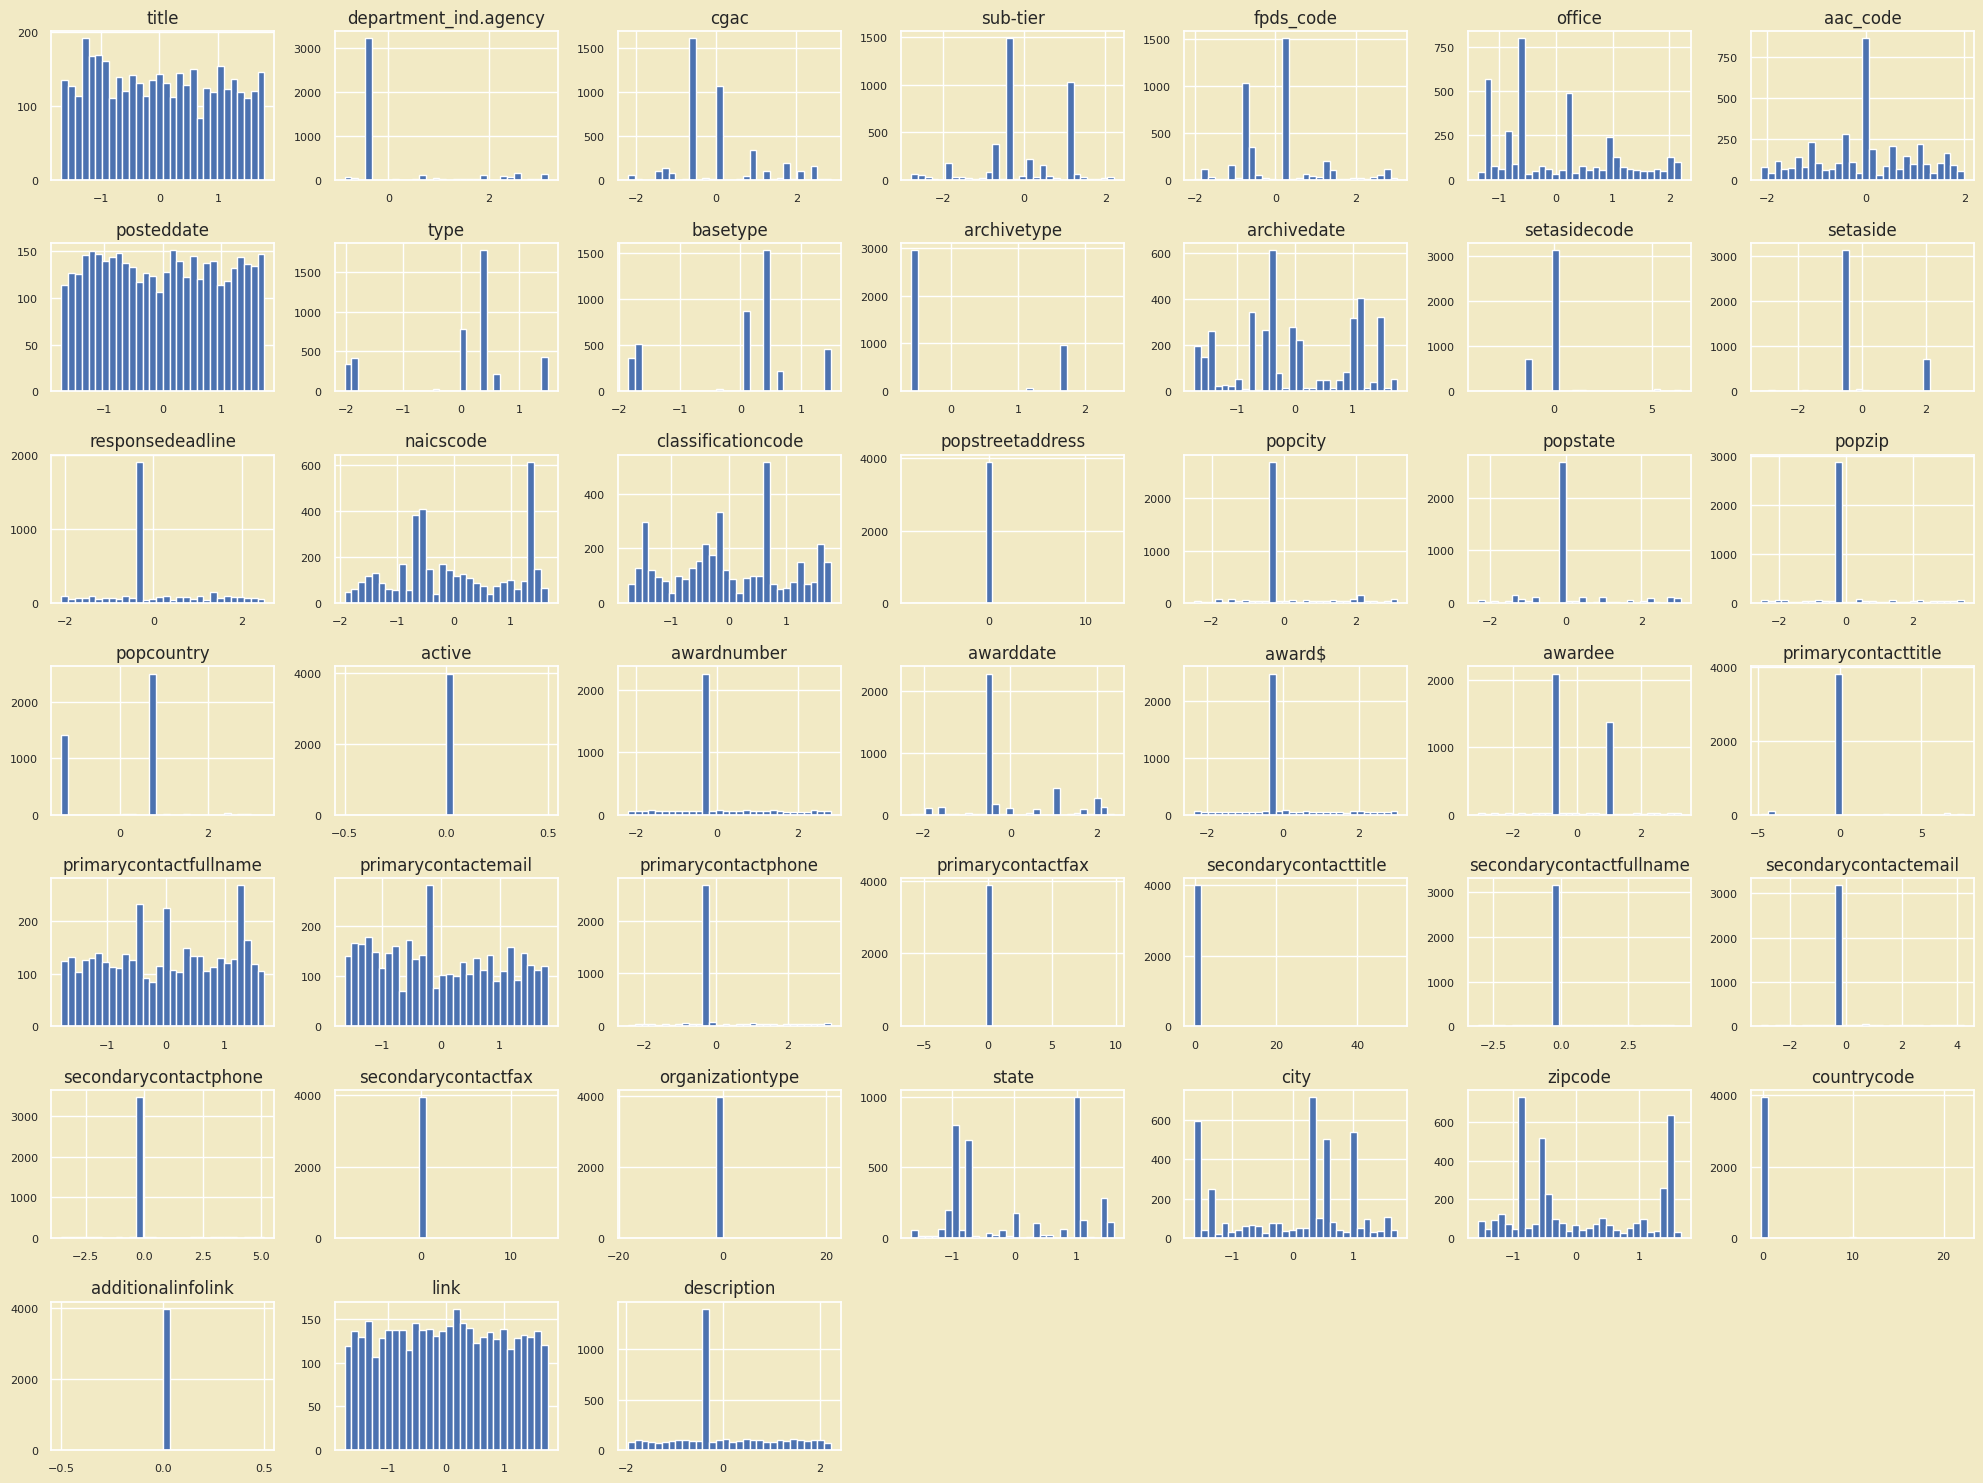

time: 7.87 s (started: 2024-11-14 05:08:29 +00:00)


In [62]:
sns.set_style('darkgrid')
sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
X_train.hist(figsize=(20,15), bins=30, xlabelsize=8, ylabelsize=8)
plt.tight_layout()
plt.show()


<a class = "anchor" id = "3"></a>
## <div style="text-align: left; background-color:#867FEE; font-family:newtimeroman;color: black; padding: 14px; line-height: 1;border-radius:10px">3. Abnormal values and outliers </div>

We can observe that the distribution as well as the range of values in the numerical columns are **no abnormal values** so we will check outliers for some columns. We will use boxplot to visualize outliers

**📙 Comment**

- `popularity`, `acousticness`, `energy`, `valence` have no outliers. (The `popularity` column has 1 outlier, but it is not significant.)
- The remaining columns exhibit a substantial number of outliers, which is understandable as they are all continuous variables. These variables have a wide range of values, do not follow a normal distribution, and are influenced by various factors of a song. Therefore, it is justifiable not to remove these outliers, as they contribute to the diversity and complexity of the dataset, reflecting the diverse nature of musical attributes.

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3989 entries, 7eefa44e7bcb4052b3f6653d8ed5d478 to 9d605a05485b4b8bad7d9372a7f08b82
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   title                     3989 non-null   float64
 1   department_ind.agency     3989 non-null   float64
 2   cgac                      3989 non-null   float64
 3   sub-tier                  3989 non-null   float64
 4   fpds_code                 3989 non-null   float64
 5   office                    3989 non-null   float64
 6   aac_code                  3989 non-null   float64
 7   posteddate                3989 non-null   float64
 8   type                      3989 non-null   float64
 9   basetype                  3989 non-null   float64
 10  archivetype               3989 non-null   float64
 11  archivedate               3989 non-null   float64
 12  setasidecode              3989 non-null   float64
 13  setaside 

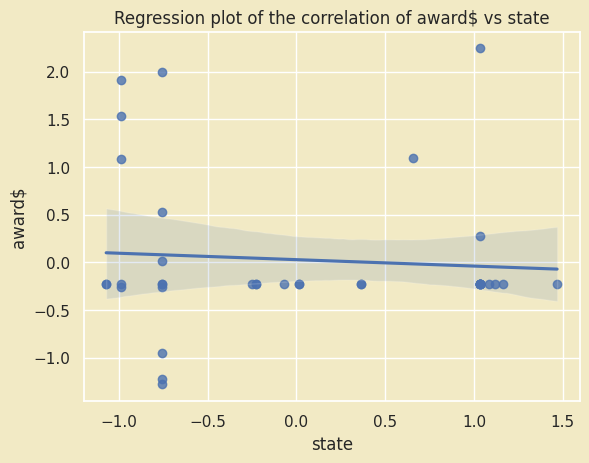

time: 259 ms (started: 2024-11-14 05:12:31 +00:00)


In [66]:
sample = X_train.sample(int(0.01 * len(X_train)))
sns.regplot(data=sample, y="award$", x="state", color="b")
plt.title("Regression plot of the correlation of award$ vs state")
plt.show()

In [69]:
avg_popularity_byzipcode = X_train.groupby('cgac')['award$'].mean().reset_index()

top3_popular_byzipcode = avg_popularity_byzipcode.nlargest(13, 'award$')
top3_popular_byzipcode

,cgac,award$
3,-1.988603,1.199982
35,2.529647,0.177016
10,-0.646624,0.172076
2,-2.044990,0.116625
36,2.862616,0.052738
7,-1.146837,0.006210
32,2.075751,-0.031867
11,-0.587631,-0.049438
33,2.132517,-0.051497
13,-0.211818,-0.057509


time: 14.6 ms (started: 2024-11-14 05:15:41 +00:00)


In [70]:
top3_genre_data = X_train[X_train['cgac'].isin(top3_popular_byzipcode['cgac'])]
top3_genre_data

,title,department_ind.agency,cgac,sub-tier,fpds_code,office,aac_code,posteddate,type,basetype,...,secondarycontactphone,secondarycontactfax,organizationtype,state,city,zipcode,countrycode,additionalinfolink,link,description
NoticeId,,,,,,,,,,,,,,,,,,,,,
b0847fa39034411791b653f3e5839b6a,1.400122,-0.421645,-0.646624,-0.342009,0.185658,-0.593205,0.174065,-0.565724,0.362067,0.409342,...,-0.123790,-0.072613,-0.007459,-0.989690,0.347545,-0.907459,-0.08261,0.0,0.310434,-0.310532
ecb4b82edf8b4f9388942a6c9aea1028,-1.159600,-0.421645,-0.646624,-0.342009,0.185658,-0.593205,1.157478,-1.454463,0.362067,0.409342,...,-0.123790,-0.072613,-0.007459,-0.989690,0.347545,-0.907459,-0.08261,0.0,1.152858,-0.310532
254b8b4646014edaa72abcddcda13d12,-0.876202,-0.421645,2.449123,0.537368,-1.095912,0.328266,-1.397458,0.963548,-1.828962,-1.675586,...,-2.973658,-0.072613,-0.007459,-1.072465,-0.658483,-1.551495,-0.08261,0.0,-1.502256,2.053169
7269a56d192e420c975775ffdc43d685,-1.237434,-0.421645,-0.646624,-0.342009,0.185658,-0.593205,0.174065,1.634825,0.362067,0.409342,...,-0.123790,-0.072613,-0.007459,-0.989690,0.347545,-0.907459,-0.08261,0.0,-0.603527,-0.310532
a9637273aeb54d7b90bcf526278010a7,0.279802,-0.421645,-0.646624,-1.605155,-1.385121,-0.398313,-0.344093,1.088476,1.497102,1.489412,...,-0.123790,-0.072613,-0.007459,-0.756441,-1.307770,-1.166785,-0.08261,0.0,-0.311014,-0.179019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98325ca187494c06b192f5b13ce893a1,-0.380803,0.617935,2.075751,0.122588,1.204381,0.024459,0.596920,0.094968,0.362067,0.097895,...,4.522782,-0.072613,-0.007459,1.468393,-1.371311,1.066344,-0.08261,0.0,0.382343,-0.310532
593cde7ff65145e2a054efe9ffc418e3,1.370360,-0.799815,-2.044990,1.468068,-1.303328,-0.021440,-0.596921,0.420684,0.567054,0.604402,...,-0.123790,-0.072613,-0.007459,-0.989690,0.347545,-0.900540,-0.08261,0.0,-0.047057,-0.105924
e0db9cdead304f91809659790f723786,-0.520295,-0.421645,-0.646624,-0.342009,0.185658,0.748556,1.160918,1.183412,0.362067,0.097895,...,-0.123790,-0.072613,-0.007459,1.397779,1.517170,-0.264965,-0.08261,0.0,1.220403,0.172439


time: 24.1 ms (started: 2024-11-14 05:16:46 +00:00)


In [72]:
!pip install matplotlib_venn hnswlib --quiet

time: 2.21 s (started: 2024-11-14 05:18:48 +00:00)


### <span style='color:#2B9C15 '> 📕 Preprocessing</span>
- Exclude the columns `department_ind.agency` and `title`.
    - The removal of the 'time_signature' and 'key' columns is due to their categorical nature. While it's possible to encode them, doing so may impact the results of the recommendation process.

In [ ]:
df.drop_duplicates(subset=['department_ind.agency'], inplace=True)
df.head(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid MichaelsonZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


time: 194 ms (started: 2024-11-13 14:03:39 +00:00)


In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

numerical_cols = df.select_dtypes(include=np.number).columns
data_norm = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols, index=df['track_id'])

time: 9.53 ms (started: 2024-11-13 14:03:39 +00:00)


In [ ]:
data_norm

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
track_id,,,,,,,,,,,,,,
5SuOikwiRyPMVoIQDJUgSV,0.73,0.042473,0.686992,0.460989,0.090909,0.767411,0.0,0.148187,0.032329,0.000001,0.352006,0.718593,0.361245,0.8
4qPNDBW1i3p13qLCt0Ki3A,0.55,0.026971,0.426829,0.165983,0.090909,0.551094,1.0,0.079067,0.927711,0.000006,0.092607,0.268342,0.318397,0.8
1iJBSr7s7jYXzM8EGcbK5b,0.57,0.038679,0.445122,0.358987,0.000000,0.705789,1.0,0.057720,0.210843,0.000000,0.108756,0.120603,0.313643,0.8
6lfxq3CG4xtTiEg7opyCyx,0.71,0.036978,0.270325,0.059581,0.000000,0.524696,1.0,0.037617,0.908635,0.000071,0.123896,0.143719,0.746758,0.6
5vjLSffimiIP26QG5WcN2K,0.82,0.036389,0.628049,0.442989,0.181818,0.706882,1.0,0.054508,0.470884,0.000000,0.074338,0.167839,0.492863,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4SCobBx8k3ZXNvj17o1NZc,0.30,0.046240,0.598577,0.712994,1.000000,0.805915,1.0,0.034715,0.139558,0.001021,0.120868,0.629146,0.517479,0.8
5PocwBP4qm33W4eQSZyVBZ,0.54,0.039286,0.631098,0.196984,0.636364,0.607849,1.0,0.059378,0.993976,0.878879,0.144083,0.571859,0.493869,0.8
2jw9uRjSU1yGjMv3YMhbho,0.29,0.047002,0.733740,0.745995,0.181818,0.764153,0.0,0.038031,0.101406,0.000000,0.042039,0.681407,0.461080,0.8


time: 95.1 ms (started: 2024-11-13 14:03:39 +00:00)


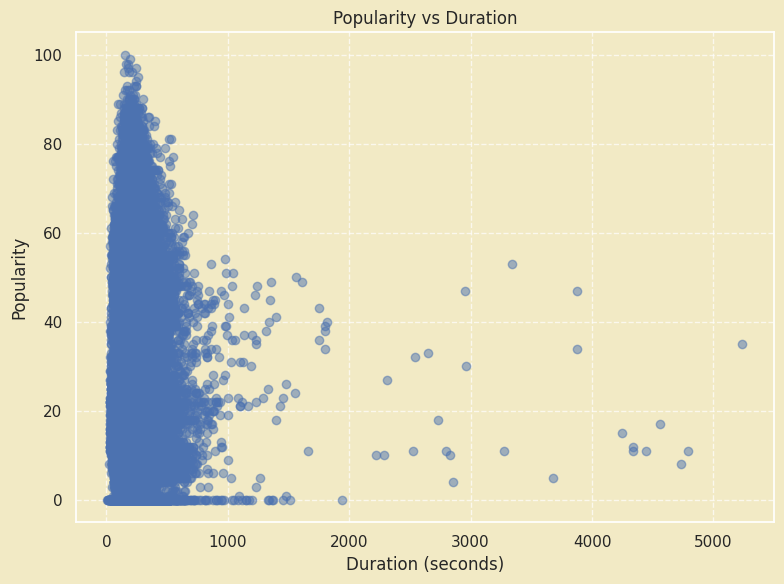

time: 349 ms (started: 2024-11-13 14:03:39 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Convert duration from milliseconds to seconds
df['duration_sec'] = df['duration_ms'] / 1000

plt.figure(figsize=(8, 6))
plt.scatter(df['duration_sec'], df['popularity'], alpha=0.5)
plt.title('Popularity vs Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Popularity')

# Improve x-axis readability
plt.ticklabel_format(style='plain', axis='x')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

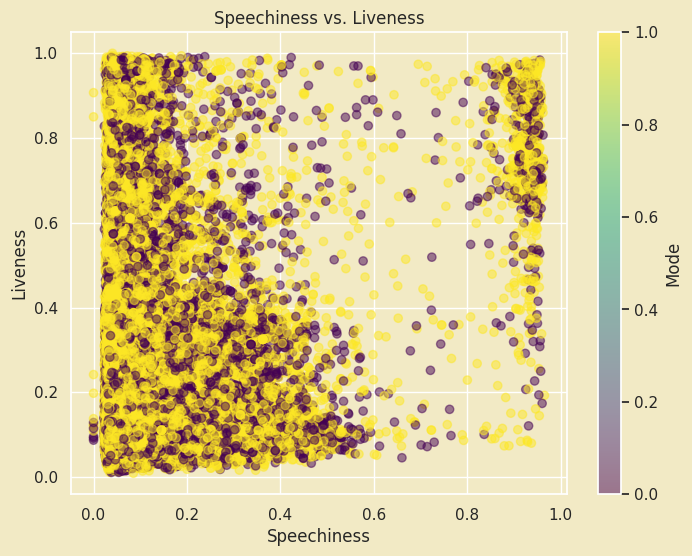

time: 2.31 s (started: 2024-11-13 14:03:39 +00:00)


In [ ]:
# @title Speechiness vs. Liveness

plt.figure(figsize=(8, 6))
plt.scatter(df['speechiness'], df['liveness'], c=df['mode'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Mode')
plt.title('Speechiness vs. Liveness')
plt.xlabel('Speechiness')
_ = plt.ylabel('Liveness')

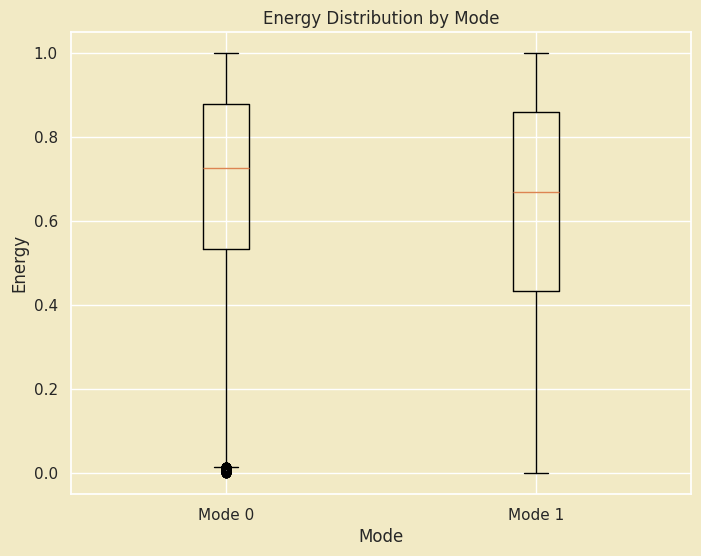

time: 237 ms (started: 2024-11-13 14:03:42 +00:00)


In [ ]:
# @title Energy Distribution by Mode

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.boxplot([df[df['mode'] == 0]['energy'], df[df['mode'] == 1]['energy']], labels=['Mode 0', 'Mode 1'])
plt.title('Energy Distribution by Mode')
plt.xlabel('Mode')
_ = plt.ylabel('Energy')

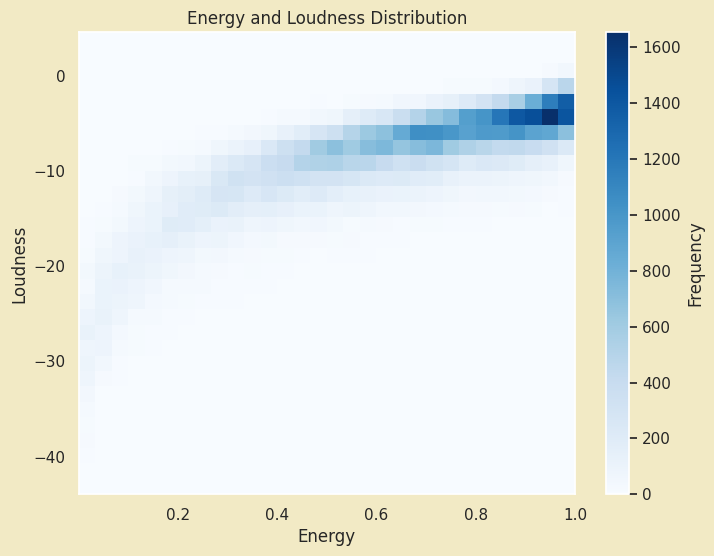

time: 351 ms (started: 2024-11-13 14:03:42 +00:00)


In [ ]:
# @title Energy and Loudness Distribution
plt.figure(figsize=(8, 6))
plt.hist2d(df['energy'], df['loudness'], bins=30, cmap='Blues')
plt.colorbar(label='Frequency')
plt.title('Energy and Loudness Distribution')
plt.xlabel('Energy')
_ = plt.ylabel('Loudness')

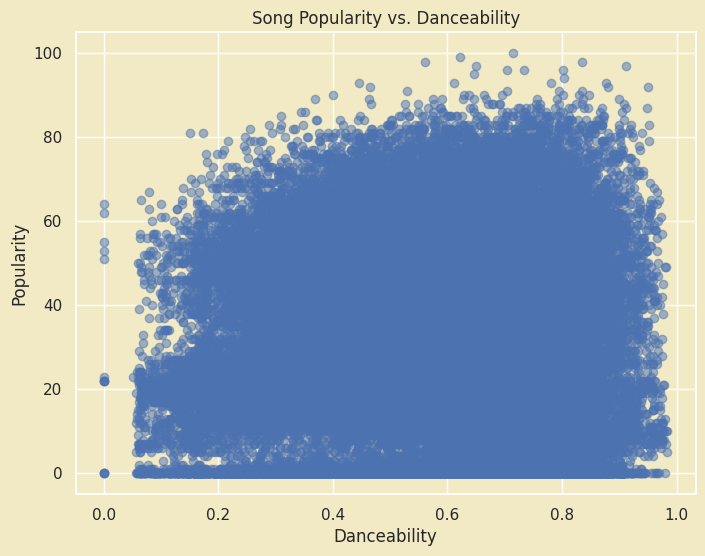

time: 513 ms (started: 2024-11-13 14:03:42 +00:00)


In [ ]:
# @title Song Popularity vs. Danceability

plt.figure(figsize=(8, 6))
plt.scatter(df['danceability'], df['popularity'], alpha=0.5)
plt.title('Song Popularity vs. Danceability')
plt.xlabel('Danceability')
_ = plt.ylabel('Popularity')

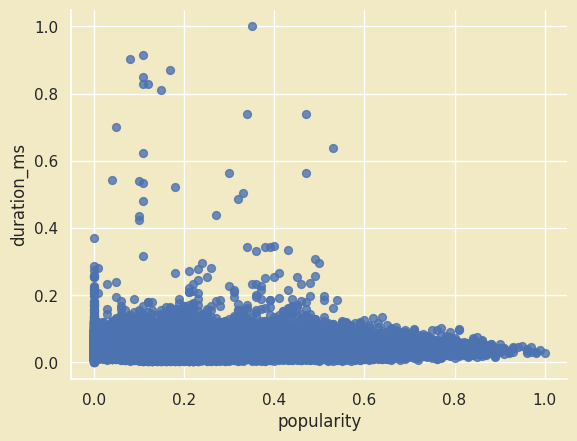

time: 465 ms (started: 2024-11-13 14:03:43 +00:00)


In [ ]:
# @title popularity vs duration_ms

from matplotlib import pyplot as plt
data_norm.plot(kind='scatter', x='popularity', y='duration_ms', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

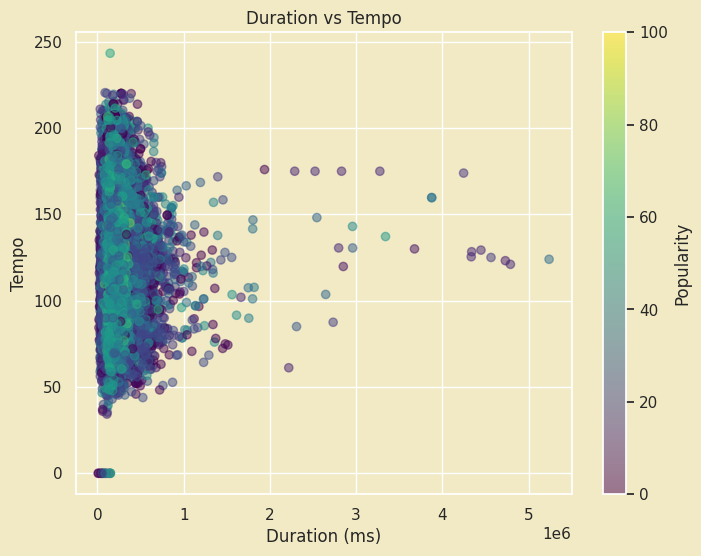

time: 2.31 s (started: 2024-11-13 14:03:43 +00:00)


In [ ]:
# @title Duration vs Tempo

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df['duration_ms'], df['tempo'], c=df['popularity'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Popularity')
plt.title('Duration vs Tempo')
plt.xlabel('Duration (ms)')
_ = plt.ylabel('Tempo')

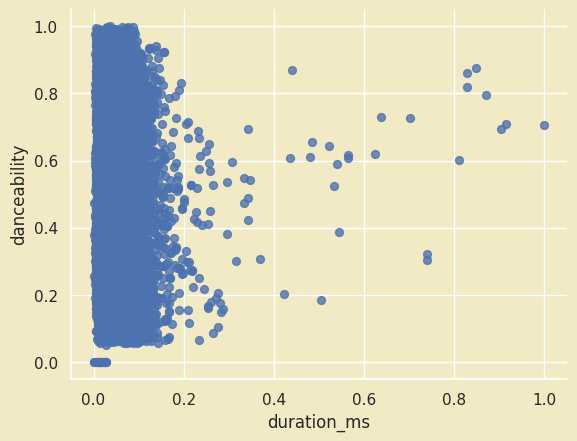

time: 452 ms (started: 2024-11-13 14:03:46 +00:00)


In [ ]:
# @title duration_ms vs danceability

from matplotlib import pyplot as plt
data_norm.plot(kind='scatter', x='duration_ms', y='danceability', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

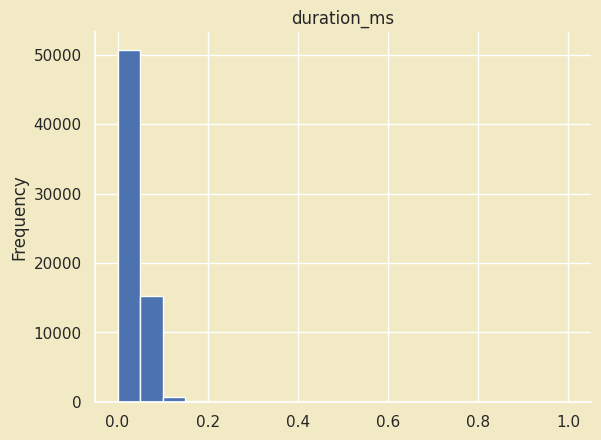

time: 232 ms (started: 2024-11-13 14:03:46 +00:00)


In [ ]:
# @title duration_ms

from matplotlib import pyplot as plt
data_norm['duration_ms'].plot(kind='hist', bins=20, title='duration_ms')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
numerical_cols

Index(['popularity', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

time: 2.51 ms (started: 2024-11-13 14:03:46 +00:00)


## Approximate Nearest Neighbor Search with Voyager

In [ ]:
# Import necessary libraries
import warnings
import pandas as pd
import numpy as np
import hnswlib
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

time: 613 µs (started: 2024-11-13 14:03:46 +00:00)


In [ ]:
# Step 1: Load the dataset
df = pd.read_csv('dataset.csv')
df = df.head(85000)
# Step 2: Data Preprocessing and Feature Engineering
# Impute missing values, handle categorical data, and scale numerical data

# Define categorical and numerical columns
categorical_cols = ['artists', 'album_name', 'track_name']

numerical_cols = ['popularity', 'duration_ms', 'danceability', 'energy',
                  'loudness', 'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence', 'tempo']


time: 299 ms (started: 2024-11-13 14:03:46 +00:00)


In [ ]:
import re

def clean_names(df):
    """
    Cleans column names of a Pandas DataFrame by removing special characters,
    converting to lowercase, and replacing spaces with underscores.

    Args:
        df: Pandas DataFrame

    Returns:
        Pandas DataFrame with cleaned column names.
    """
    new_cols = []
    for col in df.columns:
        # Remove special characters
        col = re.sub(r'[^\w\s]', '', col)
        # Convert to lowercase
        col = col.lower()
        # Replace spaces with underscores
        col = col.replace(' ', '_')
        new_cols.append(col)
    df.columns = new_cols
    return df

df = clean_names(df)

time: 813 µs (started: 2024-11-13 14:03:47 +00:00)


In [ ]:
df[numerical_cols]

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,73,230666,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.715,87.917
1,55,149610,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.267,77.489
2,57,210826,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.120,76.332
3,71,201933,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.143,181.740
4,82,198853,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.167,119.949
...,...,...,...,...,...,...,...,...,...,...,...
84995,25,169706,0.234,0.3960,-14.006,0.0394,0.401000,0.000303,0.8330,0.636,189.188
84996,26,1174026,0.545,0.7300,-10.456,0.0578,0.572000,0.227000,0.9710,0.797,88.756
84997,25,304293,0.664,0.4200,-12.807,0.0329,0.889000,0.121000,0.1300,0.642,116.518
84998,26,273466,0.480,0.5540,-7.296,0.0291,0.160000,0.016700,0.2170,0.156,137.560


time: 55.9 ms (started: 2024-11-13 14:03:47 +00:00)


In [ ]:
df[categorical_cols]

,artists,album_name,track_name
0,Gen Hoshino,Comedy,Comedy
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love
4,Chord Overstreet,Hold On,Hold On
...,...,...,...
84995,Cem Karaca;Dervişan,Parka,Bu Son Olsun
84996,Grateful Dead,So Many Roads (1965 - 1995),Scarlet Begonias / Fire on the Mountain - Live...
84997,Grateful Dead,"Veneta, OR 8/27/72: The Complete Sunshine Dayd...","El Paso - Live in Veneta, Oregon 8/27/72"
84998,Silverchair,Neon Ballroom,Black Tangled Heart


time: 132 ms (started: 2024-11-13 14:03:47 +00:00)


In [ ]:
# Basic statistics of numerical columns
df.describe()

,unnamed_0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,85000.000000,85000.000000,8.500000e+04,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000,85000.000000
mean,42499.500000,33.270000,2.312785e+05,0.564321,0.653488,5.313129,-8.113948,0.632894,0.088103,0.294817,0.165601,0.209746,0.461050,122.770227,3.910412
std,24537.530778,22.487048,1.121409e+05,0.174858,0.252684,3.552345,5.029278,0.482019,0.113847,0.329561,0.316441,0.184608,0.255053,29.414037,0.412980
min,0.000000,0.000000,0.000000e+00,0.000000,0.000020,0.000000,-43.957000,0.000000,0.000000,0.000000,0.000000,0.009250,0.000000,0.000000,0.000000
25%,21249.750000,17.000000,1.762115e+05,0.450000,0.487000,2.000000,-9.823000,0.000000,0.036100,0.011575,0.000000,0.097300,0.248000,100.002000,4.000000
50%,42499.500000,33.000000,2.153335e+05,0.576000,0.700000,5.000000,-6.813000,1.000000,0.049700,0.136000,0.000066,0.131000,0.446000,122.981000,4.000000
75%,63749.250000,51.000000,2.656590e+05,0.694000,0.867000,8.000000,-4.851000,1.000000,0.087300,0.557000,0.079400,0.271000,0.664000,140.099000,4.000000
max,84999.000000,100.000000,5.237295e+06,0.984000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,0.999000,1.000000,0.995000,243.372000,5.000000


time: 81.8 ms (started: 2024-11-13 14:03:47 +00:00)


In [ ]:
!pip install CausalPy causalpy matplotlib pytrends faiss-cpu --quiet

time: 2.92 s (started: 2024-11-13 14:07:04 +00:00)


In [ ]:
# app.py

import warnings
import pandas as pd
import numpy as np
import os
import gradio as gr
import faiss

# Suppress warnings
warnings.filterwarnings("ignore")

class SongRecommendationApp:
    def __init__(self, data_path, index_path):
        """
        Initialize the SongRecommendationApp with data from the given paths.

        Parameters:
        - data_path (str): The path to the CSV file containing song data.
        - index_path (str): The path to the FAISS index file.
        """
        self.data_path = data_path
        self.index_path = index_path
        self.df = pd.read_csv(self.data_path).head(79000)  # Load a subset for demonstration
        self.song_to_artist_mapping = {}
        self.faiss_index = None
        self.df_hashed = None
        self.df_merged = None
        self.data = None

    def preprocess_data(self):
        """
        Preprocess the data. Load preprocessed data from disk if available.
        """
        preprocessed_data_file = 'preprocessed_data.pkl'
        if os.path.exists(preprocessed_data_file):
            # Load preprocessed data
            (self.df, self.df_hashed, self.df_merged, self.data) = pd.read_pickle(preprocessed_data_file)
            print("Loaded preprocessed data from disk.")
        else:
            numerical_cols = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
                              'speechiness', 'acousticness', 'instrumentalness', 'liveness',
                              'valence', 'tempo']
            categorical_cols = ['track_id', 'artists', 'album_name', 'track_name']

            from sklearn.impute import SimpleImputer
            from sklearn.preprocessing import StandardScaler

            # Handle missing values in numerical columns
            imputer = SimpleImputer(strategy='mean')
            self.df[numerical_cols] = imputer.fit_transform(self.df[numerical_cols])

            # Fill missing values in categorical columns
            self.df[categorical_cols] = self.df[categorical_cols].fillna('unknown')

            # Remove duplicates to ensure one-to-one mapping between track_name and artists
            self.df = self.df.drop_duplicates(subset='track_name', keep='first').reset_index(drop=True)

            # Hash categorical features
            self.df_hashed = self.df.copy()
            for col in categorical_cols:
                self.df_hashed[col] = self.df_hashed[col].apply(lambda x: hash(str(x)) % 10**8)

            # Normalize numerical columns
            scaler = StandardScaler()
            self.df_hashed[numerical_cols] = scaler.fit_transform(self.df_hashed[numerical_cols])

            # Reset index to ensure unique indexing
            self.df = self.df.reset_index(drop=True)
            self.df_hashed = self.df_hashed.reset_index(drop=True)

            # Add 'index' column to both dataframes
            self.df['index'] = self.df.index
            self.df_hashed['index'] = self.df.index

            # Merge original with hashed data, using only numeric data for FAISS
            df_selected = self.df[['index', 'track_name', 'artists']]
            hashed_features = self.df_hashed[numerical_cols + ['index']]
            self.df_merged = pd.merge(df_selected, hashed_features, on='index')

            # Prepare data for FAISS (only numerical columns)
            self.data = self.df_merged[numerical_cols].values.astype(np.float32)

            # Save preprocessed data to disk
            pd.to_pickle((self.df, self.df_hashed, self.df_merged, self.data), preprocessed_data_file)
            print("Preprocessed data saved to disk.")

    def build_faiss_index(self):
        """
        Build or load the FAISS index.
        """
        if os.path.exists(self.index_path):
            # Load index
            self.faiss_index = faiss.read_index(self.index_path)
            print("Loaded FAISS index from disk.")
        else:
            dim = self.data.shape[1]
            # Build the index
            self.faiss_index = faiss.IndexFlatL2(dim)
            self.faiss_index.add(self.data)

            # Save index to disk
            faiss.write_index(self.faiss_index, self.index_path)
            print("Saved FAISS index to disk.")

    def update_artist(self, track_name):
        """
        Update the artist display based on the selected track.

        Parameters:
        - track_name (str): The selected track name.

        Returns:
        - str: The artist name associated with the selected track.
        """
        artist = self.song_to_artist_mapping.get(track_name, "Unknown Artist")
        return artist

    def get_recommendations(self, track_name_input, num_recommendations=5):
        """
        Recommend similar songs based on the selected track.

        Parameters:
        - track_name_input (str): The name of the selected track.
        - num_recommendations (int): Number of recommendations to return.

        Returns:
        - str: A string containing the list of recommended songs.
        - pandas.DataFrame: DataFrame containing recommended songs and artists.
        - numpy.ndarray: Array of distances for the recommendations.
        """
        if not track_name_input:
            return "Please select a track name.", pd.DataFrame(), np.array([])

        # Get the artist name associated with the track
        artist_input = self.song_to_artist_mapping.get(track_name_input, None)
        if not artist_input:
            return "Song not found in the dataset.", pd.DataFrame(), np.array([])

        # Find the index of the song in the dataset
        mask = (self.df_merged['track_name'].str.lower() == track_name_input.lower())
        song_indices = self.df_merged[mask].index.tolist()
        if not song_indices:
            return "Song not found in the dataset.", pd.DataFrame(), np.array([])

        song_index = song_indices[0]

        # Get the query vector
        query_vector = self.data[song_index].reshape(1, -1).astype(np.float32)

        # Perform KNN search
        distances, indices = self.faiss_index.search(query_vector, k=num_recommendations + 1)
        recommended_indices = indices[0][indices[0] != song_index][:num_recommendations]

        # Get recommendations
        recommendations = self.df_merged.iloc[recommended_indices][['track_name', 'artists']]

        # Also return distances for visualization
        distances = distances[0][indices[0] != song_index][:num_recommendations]

        # Format the recommendations
        formatted_recommendations = [f"{i+1}. {track} by {artist} (Similarity Score: {1/(d+1e-5):.2f})"
                                     for i, (track, artist, d) in enumerate(zip(recommendations['track_name'],
                                                                               recommendations['artists'], distances))]
        return "\n".join(formatted_recommendations), recommendations, distances

    def get_most_popular_songs(self, top_n=20):
        """
        Get the most popular songs from the dataset.

        Parameters:
        - top_n (int): Number of popular songs to return.

        Returns:
        - str: A formatted string of popular songs with their popularity scores.
        """
        # Sort the dataframe by 'popularity' column in descending order
        top_songs = self.df[['track_name', 'artists', 'popularity']].sort_values(by='popularity', ascending=False).head(top_n)

        # Format the top songs for display
        formatted_popular_songs = "\n".join([f"{i+1}. {track} by {artist} (Popularity Score: {pop})"
                                             for i, (track, artist, pop) in enumerate(zip(top_songs['track_name'], top_songs['artists'], top_songs['popularity']))])
        return formatted_popular_songs

    def plot_radial_similarity(self, track_name, recommendations_df, distances):
        """
        Generate a radial similarity chart for the recommendations.

        Parameters:
        - track_name (str): The name of the selected track.
        - recommendations_df (pandas.DataFrame): DataFrame containing recommended songs.
        - distances (numpy.ndarray): Array of distances for the recommendations.

        Returns:
        - matplotlib.figure.Figure: The figure containing the radial similarity chart.
        """
        import matplotlib.pyplot as plt
        import numpy as np

        if recommendations_df.empty:
            # Return an empty figure with a message
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.text(0.5, 0.5, 'No recommendations to display.',
                    horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax.axis('off')
            return fig

        # Coordinates for plotting
        num_recommendations = len(recommendations_df)
        angles = np.linspace(0, 2 * np.pi, num_recommendations, endpoint=False)
        distances_normalized = np.array(distances) / np.max(distances)  # Normalize distances

        # Define color palette
        color_palette = plt.get_cmap('tab10').colors  # 10 distinct colors
        colors = color_palette[:num_recommendations]  # Assign a unique color to each recommendation

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_aspect('equal')

        # Add concentric circles representing levels of similarity
        for radius in [0.33, 0.66, 1.0]:
            ax.add_patch(plt.Circle((0, 0), radius, color='lightgrey', fill=False, linestyle='--'))

        # Plot the recommended songs
        for i, (track, angle, radius, color) in enumerate(zip(recommendations_df['track_name'], angles, distances_normalized, colors)):
            x, y = np.cos(angle) * radius, np.sin(angle) * radius
            ax.plot(x, y, 'o', markersize=15, color=color, label=track)
            ax.text(x, y, track, fontsize=9, ha='center', va='center', color='white', weight='bold')

        # Add labels for the similarity levels
        ax.text(0, 1.05, 'Higher Similarity', ha='center', va='center', fontsize=12, color='orange', alpha=0.7)
        ax.text(0, -1.15, 'Lower Similarity', ha='center', va='center', fontsize=12, color='orange', alpha=0.7)

        # Set axis limits, remove ticks, and axis lines
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.axis('off')

        # Title
        ax.set_title(f"Tracks Similar to '{track_name}'", fontsize=14)

        # Create a legend with song names and their corresponding colors
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=track, markersize=12, markerfacecolor=color)
                   for track, color in zip(recommendations_df['track_name'], colors)]
        ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.3, 1.0))

        plt.tight_layout()
        return fig

    def plot_histograms(self):
        """
        Generate histograms of numerical columns.

        Returns:
        - matplotlib.figure.Figure: The figure containing the histograms.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        numerical_cols = [
            'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo'
        ]

        fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 10))
        axs = axs.flatten()
        for i, col in enumerate(numerical_cols):
            if i < len(axs):
                sns.histplot(self.df[col], ax=axs[i], kde=True, color='skyblue')
                axs[i].set_title(col, fontsize=12)
                axs[i].tick_params(axis='x', labelsize=10)
                axs[i].tick_params(axis='y', labelsize=10)
        # Remove empty subplots
        for j in range(i+1, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        return fig

    def plot_correlation_heatmap(self):
        """
        Generate the correlation heatmap.

        Returns:
        - matplotlib.figure.Figure: The figure containing the correlation heatmap.
        """
        import matplotlib.pyplot as plt
        import seaborn as sns

        numerical_cols = [
            'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
            'speechiness', 'acousticness', 'instrumentalness', 'liveness',
            'valence', 'tempo'
        ]

        fig, ax = plt.subplots(figsize=(12, 10))
        correlation = self.df[numerical_cols].corr()
        sns.heatmap(correlation, annot=True, cmap='cividis', ax=ax, annot_kws={"size": 10}, fmt=".2f")
        ax.set_title('Correlation Heatmap of Numerical Features', fontsize=14)
        ax.tick_params(axis='x', labelsize=10, rotation=45)
        ax.tick_params(axis='y', labelsize=10, rotation=0)
        plt.tight_layout()
        return fig

    def build_interface(self):
        """
        Build Gradio interface with separate tabs for charts and recommendation system.
        """
        # Create a dictionary mapping track names to artists
        self.song_to_artist_mapping = dict(zip(self.df['track_name'], self.df['artists']))

        song_list = sorted(list(self.song_to_artist_mapping.keys()), key=lambda x: x.lower())

        with gr.Blocks() as app:
            gr.Markdown("<h1 style='text-align: center;'>🎵 Song Recommendation System</h1>")

            with gr.Tab("Recommendations"):
                gr.Markdown("### Get Song Recommendations Quickly")

                with gr.Row():
                    # Searchable Dropdown for selecting track name
                    song_dropdown = gr.Dropdown(choices=song_list, label="Select a Track", interactive=True, type="value")

                    # Button to quickly select a random track
                    random_select = gr.Button("🎲 Lucky Track")

                with gr.Row():
                    # Textbox for displaying artist name (auto-updated)
                    artist_display = gr.Textbox(label="Artist Name", interactive=False, placeholder="Artist will be displayed here")

                with gr.Row():
                    # Button to trigger the recommendation process
                    recommend_button = gr.Button("🔍 Get Recommendations")

                with gr.Row():
                    # Output area for displaying recommendations
                    recommendation_output = gr.Textbox(label="Recommended Songs", lines=5, interactive=False, placeholder="Recommendations will appear here")

                with gr.Row():
                    # Output area for displaying radial similarity plot
                    radial_output = gr.Plot(label="Radial Similarity Plot")

                with gr.Row():
                    # Output area for displaying most popular songs
                    popular_songs_output = gr.Textbox(label="Top 20 Most Popular Songs", lines=20, interactive=False, placeholder="Most popular songs will appear here")

                with gr.Row():
                    # Button to get most popular songs
                    popular_songs_button = gr.Button("📈 Show Top 20 Most Popular Songs")

                # Update artist display dynamically when a track is selected
                song_dropdown.change(fn=self.update_artist, inputs=song_dropdown, outputs=artist_display)

                # Trigger recommendations and plot when button is clicked
                recommend_button.click(fn=self.get_recommendations_and_plot,
                                       inputs=[song_dropdown],
                                       outputs=[recommendation_output, radial_output])

                # Show most popular songs when button is clicked
                popular_songs_button.click(fn=self.get_most_popular_songs, outputs=popular_songs_output)

                # Select a random track when "Lucky Track" button is clicked
                random_select.click(fn=self.select_random_track,
                                    inputs=None, outputs=song_dropdown)

            with gr.Tab("Charts"):
                gr.Markdown("### Explore Data Visualizations")

                with gr.Accordion("Numerical Column Histograms", open=False):
                    hist_button = gr.Button("📊 Show Histograms")
                    hist_output = gr.Plot()
                    hist_button.click(fn=self.plot_histograms, inputs=None, outputs=hist_output)

                with gr.Accordion("Correlation Heatmap", open=False):
                    heatmap_button = gr.Button("🔥 Show Correlation Heatmap")
                    heatmap_output = gr.Plot()
                    heatmap_button.click(fn=self.plot_correlation_heatmap, inputs=None, outputs=heatmap_output)

            # Launch the app
            app.launch()

    def get_recommendations_and_plot(self, track_name_input):
        """
        Combined function to get recommendations and generate the radial similarity plot.

        Parameters:
        - track_name_input (str): The name of the selected track.

        Returns:
        - str: Formatted recommendations.
        - matplotlib.figure.Figure: Radial similarity plot.
        """
        recommendations_text, recommendations_df, distances = self.get_recommendations(track_name_input)
        fig = self.plot_radial_similarity(track_name_input, recommendations_df, distances)
        return recommendations_text, fig

    def select_random_track(self):
        """
        Select a random track from the dataset.

        Returns:
        - str: The name of the randomly selected track.
        """
        random_track = self.df.sample(n=1).iloc[0]['track_name']
        return random_track

# Instantiate and run the app
if __name__ == "__main__":
    dataset_path = 'dataset.csv'    # Ensure this file is in the app's directory
    index_path = 'faiss_index.bin'  # Ensure this file is in the app's directory
    app_instance = SongRecommendationApp(dataset_path, index_path)
    app_instance.preprocess_data()
    app_instance.build_faiss_index()
    app_instance.build_interface()


Preprocessed data saved to disk.
Saved FAISS index to disk.
Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fbd5ca3e19cce37f39.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


time: 5.28 s (started: 2024-11-13 14:07:11 +00:00)


In [ ]:
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import arviz as az
import causalpy as cp

# getting global Google Trends data for a key phrase of interest
# initializing the TrendReq object
pytrends = TrendReq(hl='en-US', tz=360, requests_args={'verify': False})

# specifying keyword and time range
keywords = ['How to write email']
timeframe = '2020-01-01 2024-10-31'

# creating payload and fetching data
pytrends.build_payload(keywords, cat=0, timeframe=timeframe, geo='', gprop='')

time: 69.4 ms (started: 2024-11-13 14:08:31 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data = pytrends.interest_over_time()
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,How to write email,isPartial
date,,
2019-12-29,43,False
2020-01-05,62,False
2020-01-12,64,False
2020-01-19,64,False
2020-01-26,66,False
...,...,...
2024-09-29,62,False
2024-10-06,65,False
2024-10-13,62,False


time: 181 ms (started: 2024-11-13 14:10:37 +00:00)


In [ ]:
# data overview
# data.head()
# data.info()

# creating month variable for capturing seasonality in the data
data['month'] = data.index.month

# creating time variable
data['t'] = np.arange(len(data))
data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,How to write email,isPartial,month,t
date,,,,
2019-12-29,43,False,12,0
2020-01-05,62,False,1,1
2020-01-12,64,False,1,2
2020-01-19,64,False,1,3
2020-01-26,66,False,1,4
...,...,...,...,...
2024-09-29,62,False,9,248
2024-10-06,65,False,10,249
2024-10-13,62,False,10,250


time: 19.1 ms (started: 2024-11-13 14:10:54 +00:00)


In [ ]:
# renaming target variable
data.rename(columns={'How to write email': 'y'}, inplace=True)

# saving the data for later usage
# data.to_csv('google_trends_data.csv', index=True)

# specifying the date of intervention
treatment_time = pd.to_datetime("2022-10-30")

time: 4.27 ms (started: 2024-11-13 14:11:07 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# specifying and fitting the model
seed = 2024
result = cp.InterruptedTimeSeries(
    data,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(
      sample_kwargs={
        "random_seed": seed,
        "draws": 50000,
        "tune": 1000,
        "chains": 4
      }
    ),
)

# summary of the fitted model
result.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Output()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t + C(month)
Model coefficients:
    Intercept       60, 94% HDI [57, 63]
    C(month)[T.2]   2.7, 94% HDI [-1.7, 7.1]
    C(month)[T.3]   -3.2, 94% HDI [-7.6, 1.1]
    C(month)[T.4]   -5.3, 94% HDI [-9.8, -0.87]
    C(month)[T.5]   -2.9, 94% HDI [-7.2, 1.3]
    C(month)[T.6]   -1.6, 94% HDI [-6.1, 2.9]
    C(month)[T.7]   -5.9, 94% HDI [-10, -1.5]
    C(month)[T.8]   -1.7, 94% HDI [-6.1, 2.6]
    C(month)[T.9]   1.4, 94% HDI [-3.1, 5.9]
    C(month)[T.10]  -4.9, 94% HDI [-9.4, -0.51]
    C(month)[T.11]  -10, 94% HDI [-15, -5.2]
    C(month)[T.12]  -20, 94% HDI [-25, -15]
    t               0.21, 94% HDI [0.18, 0.23]
    sigma           6, 94% HDI [5.5, 6.6]
time: 2min 52s (started: 2024-11-13 15:43:07 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


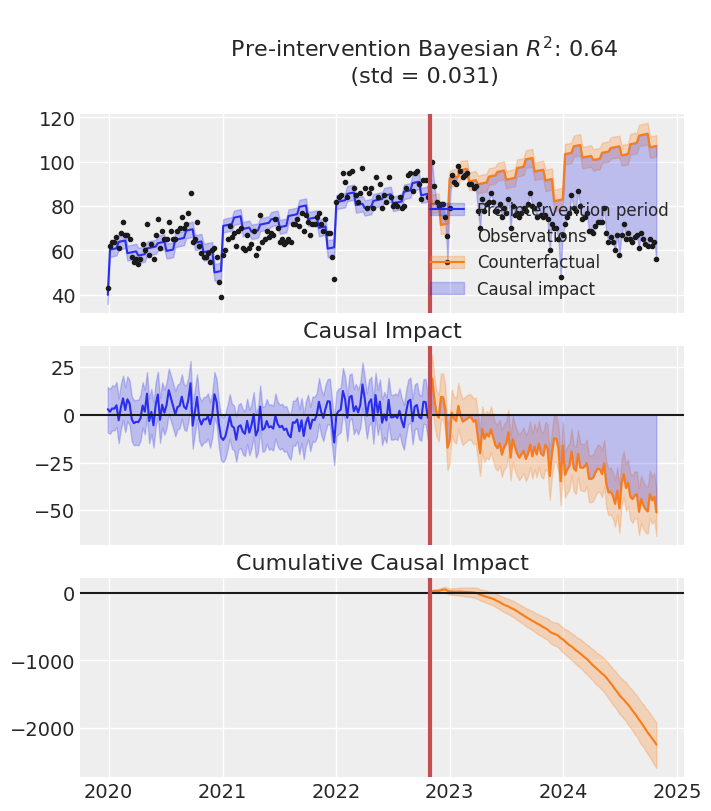

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-2250.56,179.914,-2597.584,-1924.075,1.557,1.103,13352.0,15362.0,1.0


time: 2.95 s (started: 2024-11-13 14:12:19 +00:00)


In [ ]:
# plotting the results
fig, ax = result.plot()
plt.show()

# summary statistics of the causal impact over the entire post-intervention period
az.summary(result.post_impact.mean("obs_ind"))

# summary statistics of the cumulative causal impact
# getting index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grabbing the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# getting summary stats
az.summary(last_cumulative_estimate)